# A Machine Learning Model to Predict Energy and Fatigue in Single-Task Walking Gait from Tri-axial Accelerometer, Tri-axial Gyroscope, and Tri-axial Magnetometer Signals


## Setup/Init

In [1]:
# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import MultiTaskElasticNet

import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# function definitions
def move_headers(df,headers):
  new_df = pd.DataFrame()
  for header in headers:
    new_df[header] = df[header]
  return new_df

## Data loading

In [4]:
# load data into df

df = pd.read_excel("/content/gdrive/MyDrive/EE502/Final Project/State_mental_physical_energy_fatigue_and_gait.xlsx")
df

,StartDate,EndDate,Subjectnumber,LastnightIwenttobedat,LastnightIturnedoutthelightsat,Lastnightthenumberofminutesittookmetofallasleepwas,LastnightthenumberoftimesIwokeupwas,LastnightthetotalnumberofminutesIwasawakewhenIwokeupwas,ThetimeIfinallywokeupthismorningwas,Totalnumberofhourssleptlastnight,...,PosturalSwayAccRangeCoronalms2_C,PosturalSwayAccRangeSagittalms2_C,PosturalSwayAnglesSwayAreaRadiusCoronaldegrees_C,PosturalSwayAngles95EllipseAxis2Radiusdegrees_C,PosturalSwayAnglesSwayAreaRotationdegrees_C,PosturalSwayAnglesSwayAreadegrees2_C,PosturalSwayAnglesDurations_C,PosturalSwayAnglesRMSSwaydegrees_C,PosturalSwayAnglesRMSSwayCoronaldegrees_C,PosturalSwayAnglesRMSSwaySagittaldegrees_C
0,2018-06-05 13:50:45,2018-06-05 14:13:56,24.0,11:00 PM,10:30 PM,NaN,1.0,15.0,07:30 AM,7.750,...,0.199,0.278,0.589,0.809,1.626,1.4975,29.99,0.4088,0.2411,0.3302
1,2018-06-05 13:50:37,2018-06-05 15:09:00,324.0,01:00 AM,11:00 PM,60.0,1.0,15.0,05:00 AM,4.750,...,0.401,0.431,0.787,1.099,1.147,2.7188,29.99,0.5524,0.3464,0.4302
2,2018-06-05 15:04:38,2018-06-05 15:12:22,361.0,03:00 AM,02:00 AM,20.0,1.0,17.0,06:00 AM,2.400,...,0.338,0.797,0.803,2.061,1.717,5.1969,29.99,0.9034,0.3468,0.8341
3,2018-06-06 11:15:46,2018-06-06 11:43:24,801.0,0.97916666,0.98958333,20.0,0.0,0.0,07:15 AM,7.167,...,0.235,0.498,0.663,1.347,1.584,2.8041,29.99,0.6132,0.2708,0.5501
4,2018-06-07 09:38:32,2018-06-07 10:22:49,911.0,12:30 AM,12:30 AM,10.0,0.0,0.0,08:45 AM,8.080,...,0.226,0.367,0.595,1.078,1.657,2.0139,30.00,0.5029,0.2450,0.4392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,2018-11-28 14:56:17,2018-11-28 15:23:16,94520.0,11:00 PM,09:00 PM,120.0,5.0,5.0,07:30 AM,8.416,...,0.383,0.456,0.931,1.389,1.263,4.0606,29.99,0.6829,0.4011,0.5527
130,2018-10-10 14:26:15,2018-10-10 14:37:54,95729.0,03:00 AM,12:00 AM,15.0,2.0,0.0,10:30 AM,10.250,...,0.601,0.958,1.433,2.220,1.602,9.9941,29.99,1.0793,0.5859,0.9065
131,2018-10-10 17:06:51,2018-10-10 17:18:53,97751.0,09:30 PM,10:00 PM,10.0,0.0,40.0,05:35 AM,6.750,...,0.324,0.478,0.748,1.243,1.482,2.9217,29.99,0.5926,0.3078,0.5065
132,2018-11-29 12:39:07,2018-11-29 13:05:26,99120.0,12:00 AM,11:30 PM,30.0,15.0,0.0,07:00 AM,7.000,...,0.403,0.445,1.033,1.145,1.921,3.7140,29.99,0.6298,0.4276,0.4624


In [5]:
# set up ground truths

y = move_headers(df,["StatePhysicalEnergy","StatePhysicalFatigue","StateMentalEnergy","StateMentalFatigue"])
y

,StatePhysicalEnergy,StatePhysicalFatigue,StateMentalEnergy,StateMentalFatigue
0,268.0,3.0,262.0,2.0
1,182.0,265.0,149.0,224.0
2,110.0,120.0,156.0,136.0
3,98.0,80.0,32.0,215.0
4,50.0,0.0,50.0,0.0
...,...,...,...,...
129,140.0,70.0,130.0,60.0
130,135.0,175.0,120.0,204.0
131,80.0,131.0,124.0,117.0
132,190.0,260.0,185.0,255.0


In [6]:
# set up control variables

c = move_headers(df,["Sex","Heightcm","WeightinKG"])
c

,Sex,Heightcm,WeightinKG
0,2.0,167.64,47.727273
1,1.0,175.26,73.636364
2,2.0,165.10,83.181818
3,2.0,170.18,71.363636
4,1.0,175.26,68.000000
...,...,...,...
129,2.0,167.64,67.090909
130,1.0,185.42,66.363636
131,2.0,162.56,99.909091
132,2.0,160.02,51.454545


In [7]:
# set up predictor variables

header_str = "AnticipatoryPosturalAdjustmentAPADurations AnticipatoryPosturalAdjustmentFirstStepDurations	AnticipatoryPosturalAdjustmentFirstStepRangeofMotiondegrees	AnticipatoryPosturalAdjustmentForwardAPAPeakms2	AnticipatoryPosturalAdjustmentLateralAPAPeakms2	Durations	GaitJointBackRightLat.BendMax.degreesmean	GaitJointBackRightLat.BendMax.degreesstd	GaitJointBackLeftLat.BendMax.degreesmean	GaitJointBackLeftLat.BendMax.degreesstd	GaitJointBackRLLatBendRangedegreesmean	GaitJointBackRLLatBendRangedegreesstd	GaitJointBackFlexExtMax.degreesmean	GaitJointBackFlexExtMax.degreesstd	GaitJointBackFlexExtMin.degreesmean	GaitJointBackFlexExtMin.degreesstd	GaitJointBackFlexExtRangedegreesmean	GaitJointBackFlexExtRangedegreesstd	GaitJointBackRightRotMax.degreesmean	GaitJointBackRightRotMax.degreesstd	GaitJointBackLeftRotMax.degreesmean	GaitJointBackLeftRotMax.degreesstd	GaitJointBackRLRotRangedegreesmean	GaitJointBackRLRotRangedegreesstd	GaitJointNeckRightLat.BendMax.degreesmean	GaitJointNeckRightLat.BendMax.degreesstd	GaitJointNeckLeftLat.BendMax.degreesmean	GaitJointNeckLeftLat.BendMax.degreesstd	GaitJointNeckRLLat.BendRangedegreesmean	GaitJointNeckRLLat.BendRangedegreesstd	GaitJointNeckFlexExtMax.degreesmean	GaitJointNeckFlexExtMax.degreesstd	GaitJointNeckFlexExtMin.degreesmean	GaitJointNeckFlexExtMin.degreesstd	GaitJointNeckFlexExtRangedegreesmean	GaitJointNeckFlexExtRangedegreesstd	GaitJointNeckRightRotMax.degreesmean	GaitJointNeckRightRotMax.degreesstd	GaitJointNeckLeftRotMax.degreesmean	GaitJointNeckLeftRotMax.degreesstd	GaitJointNeckRLRotRangedegreesmean	GaitJointNeckRLRotRangedegreesstd	GaitLowerLimbCadenceLstepsminmean	GaitLowerLimbCadenceLstepsminstd	GaitLowerLimbCadenceRstepsminmean	GaitLowerLimbCadenceRstepsminstd	Avgcadence	Cadenceasymmetry	GaitLowerLimbDoubleSupportLGCTmean	GaitLowerLimbDoubleSupportLGCTstd	GaitLowerLimbDoubleSupportRGCTmean	GaitLowerLimbDoubleSupportRGCTstd	AvgdoublelegsupportofGCT	AsymetriesdoublelegsupportGCT	GaitLowerLimbElevationatMidswingLcmmean	GaitLowerLimbElevationatMidswingLcmstd	GaitLowerLimbElevationatMidswingRcmmean	GaitLowerLimbElevationatMidswingRcmstd	Avgmidswingelevation	Asymetrymidswingelevation	GaitLowerLimbGaitCycleDurationLsmean	GaitLowerLimbGaitCycleDurationLsstd	GaitLowerLimbGaitCycleDurationRsmean	GaitLowerLimbGaitCycleDurationRsstd	Avggaitcycleduration	Asymmetrygaitcycleduration	GaitLowerLimbGaitSpeedLmsmean	GaitLowerLimbGaitSpeedLmsstd	GaitLowerLimbGaitSpeedRmsmean	GaitLowerLimbGaitSpeedRmsstd	Avggaitspeed	Asymmetrygaitspeed	GaitLowerLimbLateralStepVariabilityLcm	GaitLowerLimbLateralStepVariabilityRcm	Avgstepvariability	Asymmetrystepvariability	GaitLowerLimbCircumductionLcmmean	GaitLowerLimbCircumductionLcmstd	GaitLowerLimbCircumductionRcmmean	GaitLowerLimbCircumductionRcmstd	Avgcircumduction	Asymmetrycircumdunction	GaitLowerLimbN#	GaitLowerLimbFootStrikeAngleLdegreesmean	GaitLowerLimbFootStrikeAngleLdegreesstd	GaitLowerLimbFootStrikeAngleRdegreesmean	GaitLowerLimbFootStrikeAngleRdegreesstd	Avgfootstrikeangle	Asymmetryfootstrikeangle	GaitLowerLimbToeOffAngleLdegreesmean	GaitLowerLimbToeOffAngleLdegreesstd	GaitLowerLimbToeOffAngleRdegreesmean	GaitLowerLimbToeOffAngleRdegreesstd	AvgToeoutangle	AsymmetryToeoutangle	GaitLowerLimbSingleLimbSupportLGCTmean	GaitLowerLimbSingleLimbSupportLGCTstd	GaitLowerLimbSingleLimbSupportRGCTmean	GaitLowerLimbSingleLimbSupportRGCTstd	AvgSinglelegsupportofGCT	AsymmetrySinglelegsupportofGCT	GaitLowerLimbStanceLGCTmean	GaitLowerLimbStanceLGCTstd	GaitLowerLimbStanceRGCTmean	GaitLowerLimbStanceRGCTstd	AvgStanceofGCT	AsymmetrystanceofGCT	GaitLowerLimbStepDurationLsmean	GaitLowerLimbStepDurationLsstd	GaitLowerLimbStepDurationRsmean	GaitLowerLimbStepDurationRsstd	Avgstepduration	Asymmetrystepduration	GaitLowerLimbStrideLengthLmmean	GaitLowerLimbStrideLengthLmstd	GaitLowerLimbStrideLengthRmmean	GaitLowerLimbStrideLengthRmstd	Avgstridelength	Asymmetrystridelength	GaitLowerLimbSwingLGCTmean	GaitLowerLimbSwingLGCTstd	GaitLowerLimbSwingRGCTmean	GaitLowerLimbSwingRGCTstd	AvgswingofGCT	AsymmetryswingofGCT	GaitLowerLimbTerminalDoubleSupportLGCTmean	GaitLowerLimbTerminalDoubleSupportLGCTstd	GaitLowerLimbTerminalDoubleSupportRGCTmean	GaitLowerLimbTerminalDoubleSupportRGCTstd	AvgterminaldoublelegsupportofGCT	AsymmetryterminaldoublelegsupportofGCT	GaitLowerLimbToeOutAngleLdegreesmean	GaitLowerLimbToeOutAngleLdegreesstd	GaitLowerLimbToeOutAngleRdegreesmean	GaitLowerLimbToeOutAngleRdegreesstd	AvgToeoutangle_A	AsymmetryAvgToeoutangle	GaitLumbarCoronalRangeofMotiondegreesmean	GaitLumbarCoronalRangeofMotiondegreesstd	GaitLumbarSagittalRangeofMotiondegreesmean	GaitLumbarSagittalRangeofMotiondegreesstd	GaitLumbarTransverseRangeofMotiondegreesmean	GaitLumbarTransverseRangeofMotiondegreesstd	GaitTrunkCoronalRangeofMotiondegreesmean	GaitTrunkCoronalRangeofMotiondegreesstd	GaitTrunkSagittalRangeofMotiondegreesmean	GaitTrunkSagittalRangeofMotiondegreesstd	GaitTrunkTransverseRangeofMotiondegreesmean	GaitTrunkTransverseRangeofMotiondegreesstd	GaitUpperLimbArmSwingVelocityLdegreessmean	GaitUpperLimbArmSwingVelocityLdegreessstd	GaitUpperLimbArmSwingVelocityRdegreessmean	GaitUpperLimbArmSwingVelocityRdegreessstd	AvgUpperArmswingvelocity	Asymmetryupperarmswingvelocity	GaitUpperLimbArmRangeofMotionLdegreesmean	GaitUpperLimbArmRangeofMotionLdegreesstd	GaitUpperLimbArmRangeofMotionRdegreesmean	GaitUpperLimbArmRangeofMotionRdegreesstd	AvgupperarmROM	AsymmetryupperarmROM	TurnsAngledegreesmean	TurnsAngledegreesstd	TurnsDurationsmean	TurnsDurationsstd	TurnsN#	TurnsTurnVelocitydegreessmean	TurnsTurnVelocitydegreessstd	TurnsStepsinTurn#mean	TurnsStepsinTurn#std"
X = move_headers(df,header_str.split())
del header_str
X

<ipython-input-3-f57919feec0f>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[header] = df[header]


,AnticipatoryPosturalAdjustmentAPADurations,AnticipatoryPosturalAdjustmentFirstStepDurations,AnticipatoryPosturalAdjustmentFirstStepRangeofMotiondegrees,AnticipatoryPosturalAdjustmentForwardAPAPeakms2,AnticipatoryPosturalAdjustmentLateralAPAPeakms2,Durations,GaitJointBackRightLat.BendMax.degreesmean,GaitJointBackRightLat.BendMax.degreesstd,GaitJointBackLeftLat.BendMax.degreesmean,GaitJointBackLeftLat.BendMax.degreesstd,...,AsymmetryupperarmROM,TurnsAngledegreesmean,TurnsAngledegreesstd,TurnsDurationsmean,TurnsDurationsstd,TurnsN#,TurnsTurnVelocitydegreessmean,TurnsTurnVelocitydegreessstd,TurnsStepsinTurn#mean,TurnsStepsinTurn#std
0,0.34,0.51,20.06,0.29,0.95,119.99,3.52,1.31,5.26,1.30,...,8.201020,183.77,5.13,2.13,0.27,20.0,174.82,16.94,3.70,0.47
1,0.34,0.55,33.36,0.17,0.65,119.99,6.79,0.76,0.62,0.91,...,10.668770,186.45,5.39,2.26,0.35,18.0,175.68,21.39,3.56,0.78
2,0.48,0.49,25.59,0.31,0.84,119.99,5.79,1.57,3.72,1.31,...,30.418896,187.14,8.40,1.86,0.19,24.0,222.75,27.66,3.38,0.58
3,0.52,0.48,49.00,0.58,0.53,119.99,4.44,0.96,6.44,1.18,...,0.463958,187.22,5.53,1.95,0.15,21.0,191.90,12.92,3.81,0.40
4,0.47,0.49,25.40,0.19,0.52,119.99,3.32,0.76,2.39,0.92,...,18.915231,184.25,3.59,2.28,0.20,15.0,152.20,11.93,3.80,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.35,0.66,24.79,0.25,0.16,119.99,4.84,1.16,2.37,1.55,...,22.205695,181.05,19.93,2.53,0.56,14.0,147.17,14.60,3.93,0.73
130,0.39,0.67,16.09,0.18,0.36,119.99,3.24,1.21,5.55,1.14,...,8.573474,182.85,6.77,1.97,0.20,19.0,197.59,23.54,3.11,0.57
131,0.55,0.54,22.41,0.26,0.17,119.99,4.89,0.95,3.99,0.66,...,9.174877,189.89,3.43,2.44,0.34,15.0,143.45,14.29,3.80,0.68
132,NaN,NaN,NaN,NaN,NaN,119.98,-0.88,1.07,4.14,1.33,...,15.252871,179.67,5.50,2.73,0.05,10.0,149.20,10.69,3.20,0.42


## Data Pre-processing

In [8]:
# interoplate the missing values
# fill all 'NaN' with the median of that column
# https://www.kaggle.com/code/cast42/feature-selection-and-elastic-net/notebook
for feature in X.columns:
  X[feature].fillna(X[feature].median(), inplace = True)
for feature in y.columns:
  y[feature].fillna(y[feature].median(), inplace = True)
for feature in c.columns:
  c[feature].fillna(c[feature].median(), inplace = True)

In [9]:
# check for outliers
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X)

# remove outliers
X = X.reset_index()
y = y.reset_index()
c = c.reset_index()
for i in range(len(yhat)):
  if yhat[i] == -1:
    X.drop([i], axis=0, inplace=True)
    y.drop([i], axis=0, inplace=True)
    c.drop([i], axis=0, inplace=True)
del X["index"]
del y["index"]
del c["index"]
print(X.shape)

(120, 170)


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [10]:
# normalize X
scaler = StandardScaler() # preforms z = (x - u) / s
scaler.fit(X)
X = pd.DataFrame(data=scaler.transform(X),columns=X.columns)

## Training and Analysis

In [11]:
#hyperparameter tuning

# hyperparameters:
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
max_iter = [1000, 10000]
l1_ratio = np.arange(0.0, 1.0, 0.1)
selection = ["random","cyclic"]

elastic_gso = GridSearchCV(
    estimator=MultiTaskElasticNet(),
    param_grid = {
        "alpha" : alpha,
        "max_iter" : max_iter,
        "l1_ratio" : l1_ratio,
        "selection" : selection
    },
    scoring= "r2",
    cv = 5
)
elastic_gso.fit(X,y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:2441: UserWarning: Coordinate descent with l1_reg=0 may lead to unexpected results and is discouraged.
  ) = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:2441: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339.31746277916926, tolerance: 148.37235625000002
  ) = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:2441: UserWarning: Coordinate descent with l1_reg=0 may lead to unexpected results and is discouraged.
  ) = cd_fast.enet_coordinate_descent_multi_task(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:2441: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 574.7184254627088, tol

GridSearchCV(cv=5, estimator=MultiTaskElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [1000, 10000],
                         'selection': ['random', 'cyclic']},
             scoring='r2')

In [12]:
# Use the best parameters to select features
print("Best Parameters from Grid Search: ", elastic_gso.best_params_)
bp = elastic_gso.best_params_
elastic = MultiTaskElasticNet(
    alpha=bp["alpha"],
    l1_ratio=bp["l1_ratio"],
    max_iter=bp["max_iter"],
    selection = bp["selection"]
)
elastic.fit(X,y)

Best Parameters from Grid Search:  {'alpha': 10, 'l1_ratio': 0.6000000000000001, 'max_iter': 1000, 'selection': 'cyclic'}


MultiTaskElasticNet(alpha=10, l1_ratio=0.6000000000000001)

In [13]:
# Show the best 6 features for each output and their scores (higher is better)
phEn_coef = pd.Series(elastic.coef_[0,:], index = X.columns)
phFa_coef = pd.Series(elastic.coef_[1,:], index = X.columns)
meEn_coef = pd.Series(elastic.coef_[2,:], index = X.columns)
meFa_coef = pd.Series(elastic.coef_[3,:], index = X.columns)

print("Top 6 features for Phyiscal Energy: ")
print(phEn_coef.sort_values().tail(6))
print("\n\nTop 6 features for Phyiscal Fatigue: ")
print(phFa_coef.sort_values().tail(6))
print("\n\nTop 6 features for Mental Energy: ")
print(meEn_coef.sort_values().tail(6))
print("\n\nTop 6 features fpr Mental Fatigue: ")
print(meFa_coef.sort_values().tail(6))

Top 6 features for Phyiscal Energy: 
GaitTrunkCoronalRangeofMotiondegreesmean    0.897850
Durations                                   0.900664
Asymmetrystepvariability                    0.948165
GaitLowerLimbFootStrikeAngleRdegreesstd     1.030075
TurnsDurationsstd                           1.153173
TurnsStepsinTurn#std                        2.115040
dtype: float64


Top 6 features for Phyiscal Fatigue: 
GaitJointBackFlexExtRangedegreesstd          1.083753
GaitLumbarCoronalRangeofMotiondegreesmean    1.256347
GaitJointBackFlexExtMax.degreesmean          1.323389
GaitLowerLimbN#                              1.342137
GaitJointBackFlexExtMin.degreesmean          1.374689
GaitLowerLimbToeOffAngleRdegreesmean         1.666887
dtype: float64


Top 6 features for Mental Energy: 
GaitUpperLimbArmSwingVelocityRdegreessstd    0.913206
GaitLowerLimbFootStrikeAngleLdegreesstd      0.999917
GaitLowerLimbFootStrikeAngleRdegreesstd      1.019604
TurnsDurationsstd                            1.36243

In [14]:
# train with best parameters and best features
features = list(phEn_coef.sort_values().tail(6).index) + list(phFa_coef.sort_values().tail(6).index) + list(meEn_coef.sort_values().tail(6).index) + list(meFa_coef.sort_values().tail(6).index)
features = list(set(features))
features
X = X[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
elastic = MultiTaskElasticNet(    
    alpha=bp["alpha"],
    l1_ratio=bp["l1_ratio"],
    max_iter=bp["max_iter"],
    selection = bp["selection"]
)
elastic.fit(X_train,y_train)

MultiTaskElasticNet(alpha=10, l1_ratio=0.6000000000000001)

In [15]:
# export feature set to excel file
new_dataset = y.copy()
for col in c.columns:
  new_dataset[col] = c[col]
for col in X.columns:
  new_dataset[col] = X[col]
new_dataset.to_excel("/content/gdrive/MyDrive/EE502/Final Project/featureset.xlsx")

In [16]:
# compute average distance from the gt and prediction for each output variable
y_pred = elastic.predict(X_test)
cols = y.columns
y_test_prime = y_test.to_numpy()
n,m = y_pred.shape
for i in range(m):
  dist = 0
  for j in range(n):
    dist += abs(y_test_prime[j,i] - y_pred[j,i])
  print(f"{cols[i]} Average Distance: {dist/n}")


StatePhysicalEnergy Average Distance: 45.32605729925718
StatePhysicalFatigue Average Distance: 42.342417435174276
StateMentalEnergy Average Distance: 49.347808447411644
StateMentalFatigue Average Distance: 46.57697487186286


Residual for  StatePhysicalEnergy


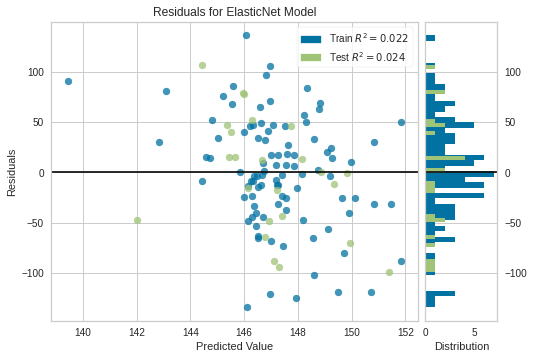

Residual for  StatePhysicalFatigue


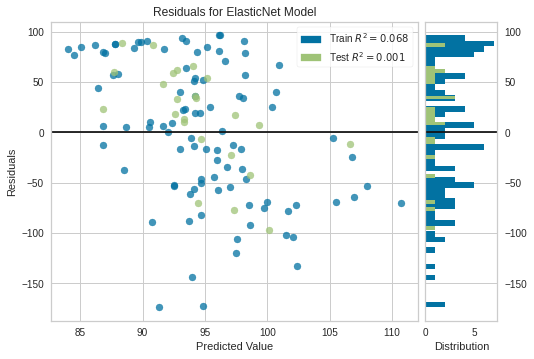

Residual for  StateMentalEnergy


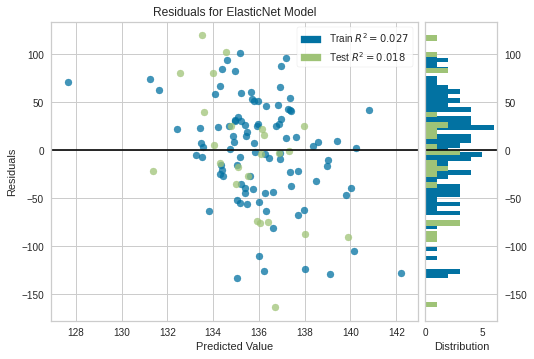

Residual for  StateMentalFatigue


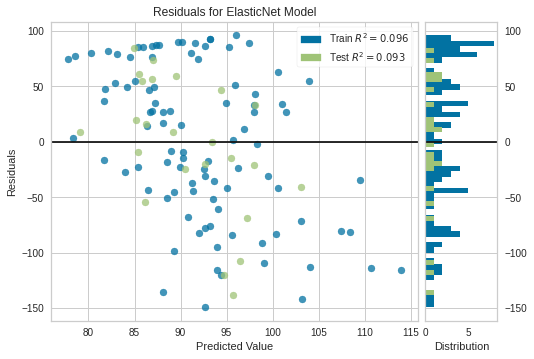

In [17]:
# show the residuals of the model
from yellowbrick.regressor import ResidualsPlot
from  sklearn.linear_model import ElasticNet

for col in y.columns:
  print("Residual for ",col)
  net = ElasticNet(
    alpha=bp["alpha"],
    l1_ratio=bp["l1_ratio"],
    max_iter=bp["max_iter"],
    selection = bp["selection"]
  )
  visualizer = ResidualsPlot(net)

  visualizer.fit(X_train, y_train[col])  # Fit the training data to the visualizer
  visualizer.score(X_test, y_test[col])  # Evaluate the model on the test data
  visualizer.show()             